# Stock Market Prediction
### 50.038 Computational Data Science


### Meeting Minutes 23/10/18
---
**Dataset used**
* AAPL
* Daily
* 2005-2018 (13 * 365 = 4745 observations)

**Problem**
* Classify the direction of price on daily, weekly and monthly basis (i.e. next day, next week, next month)

**Preliminary data exploration**
* Logarithm to stabilise data
* Technical and fundamental indicators (RSI, MA, Sharpe ratio, profit margin)
* Data visualisation (candlestick, line chart, histogram)
* Describing characteristics of data (seasonality, trend, outlier, stationarity)
* Data decomposition into seasonal, trend, noise
* Categorise the data into fixed sets of classes

**Sources of data**
* IEX API
* Yahoo Finance
* Quandl
* Twitter API with TextBlob 

**Questions**
* How to incporate non-sequential data, such as revenue, profit, loss into time-series model (e.g. ARIMA)? 
* Would using a neural network model work in integrating both high-frequency (e.g. historical data) and low-frequency data (e.g. quarterly revenue)?
* ARIMA is focused on forecasting prices based on current data. How would it be possible to combine other time-series data, such as volume trade into the ARIMA model?
* How much data would be sufficient to build a good model
* Difference between logarithm and MA in smoothing the dataset
* What is the purpose of first-degree differencing?

**Remarks from prof consultation on 24 Nov**
* How to incorporate non-sequential data, such as revenue, profit, loss into time-series model (e.g. ARIMA)?
    
Possible to average out revenue between two quarters. Draw a line between two quarter revenue like linear intrapolation and use that as a time-series data. 

* Would using a neural network model work in integrating both high-frequency (e.g. historical data) and low-frequency data (e.g. quarterly revenue)?

Might work. Can experiment

* ARIMA is focused on forecasting prices based on current data. How would it be possible to combine other time-series data, such as volume trade into the ARIMA model?

Normalize the datapoint and apply a weighted sum across these variables. Another way would be to use linear regression with multiple features. E.g. if there are 3 features (historical price, 20-day MA, 100-day MA), we can train a linear regression model with 3 features). Note that linear regression might be good at identifying short term trends.

* How much data would be sufficient to build a good model

This depends on the model itself. 

* Difference between logarithm and MA in smoothing the dataset

Prof is unsure what does logarithm do. Can try both and report the results

* What is the purpose of first-degree differencing?

Differencing helps to achieve stationarity, which is a necessary condition in ARIMA. The first-degree differencing of stock price generally works because the mean usually centers around 0. 

Other comments
* If using neural network, there are many parameters to experiment with (i.e. number of hidden layers etc)
* Try using data from other companies in the same sector as well (i.e. use Google, Microsoft and Apple) because most of these stocks follow the same trend. This generates more datapoint for us
* Sometimes, certain stocks follow certain cycles. E.g. retail stocks, such as Walmart might have a higher stock price near the Christmas season
* To create a more robust model, train with different periods (i.e. {train 1990-1995 and test on 1996},{train 2000-2005 and test on 2006})
* Augmenting data is like using 'sentiment analysis' to augment the price dataset. Combining data is like combining price and revenue. Preprocessing data is like converting raw text into bag-of-words representation or using moving average to smooth the dataset

## 1. Problem Definition
---
_Objective: Predicting whether a stock will rise or fall over different time horizons (i.e. daily, weekly and monthly basis) based on past information from fundemental and technical analysis_

Forecasting stock price movement is a central idea in the financial industry with investors and traders alike making a living through rigorous analysis of companies and determining whether stock prices will rise or fall in the future. However, stock price movement has been known to be difficult to predict due to its inherent noisy (e.g. Trump's trade wars with Russia) and complex (e.g. a result of multiple factors) nature. Furthermore, movements in stock prices differ significantly along various time scale, where it is often the case that the next-day price movement is likely to be different from next-month price movement.

Most would agree that stock prices function as a proxy to the _true value_ of a company, where for instance, it is observed that the stock price of Apple, an up and rising technology company is generally higher than that of General Motors, which is a traditional motors company in a sunset industry in recent years. To understand the _true value_ of a company, there are two school of thoughts: fundemental and technical analysis. A fundemental analysis of a company through the use of financial indicators, such as profit margin, price-earning ratios and inventory turnover provides rich information about the strength of its underlying fundementals. This is often critical to understanding the performance of a company in terms of its profitability and operational efficiency. On the other hand, a technical analysis of a company uses historical price to glean information about price trends and patterns and can be used to forecast future price movements. Hence, our group believes that the use of indicators from both a fundemental and technical point of view would offer a more comprehensive picture through which a model can make better predictions about prices. 

## 2. Data Collection and Pre-processing
---

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AR

plt.style.use("seaborn")

### Description of dataset

Dataset to be used: 
* Stock prices of Apple (NASDAQ: AAPL) - Source: Yahoo Finance

Daily stock prices of AAPL are from 01 October 2005 to 01 October 2018 are extracted from Yahoo Finance website, which is stored in a csv file format. The dataset contains the open, high, low, close and adjusted close of the AAPL stock throughout these thirteen years. This period is specifically chosen because 2005 marks the beginning of Apple's rise to dominance in the smartphone market with the introduction of the iPhone, as well as in the personal computer market with the increasingly popularity of the MacBook, which results in the tremendous increase in AAPL stock price

* Financial statements of Apple - Source: Bloomberg Terminal

Quaterly financial data from Q4 2008 to Q3 2018 are manually extracted from Bloomberg terminal into Excel files since financial information about company's fundementals are largely paid on the Internet. This includes data on balance sheet, income statement, profitability ratio, liquidity ratio etc.

### Data extraction and plotting of price
Load the data and plot it

In [10]:
aapl = pd.read_csv("AAPL - price.csv", parse_dates=[0])
aapl.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2005-09-30,7.475714,7.664286,7.411428,7.658571,5.146554,132908300
1,2005-10-03,7.737143,7.791429,7.668571,7.777143,5.226236,126888300
2,2005-10-04,7.850000,7.907143,7.662857,7.678571,5.159996,134864800
3,2005-10-05,7.761428,7.765714,7.535714,7.540000,5.066875,152692400
4,2005-10-06,7.600000,7.641428,7.267143,7.385714,4.963196,189384300


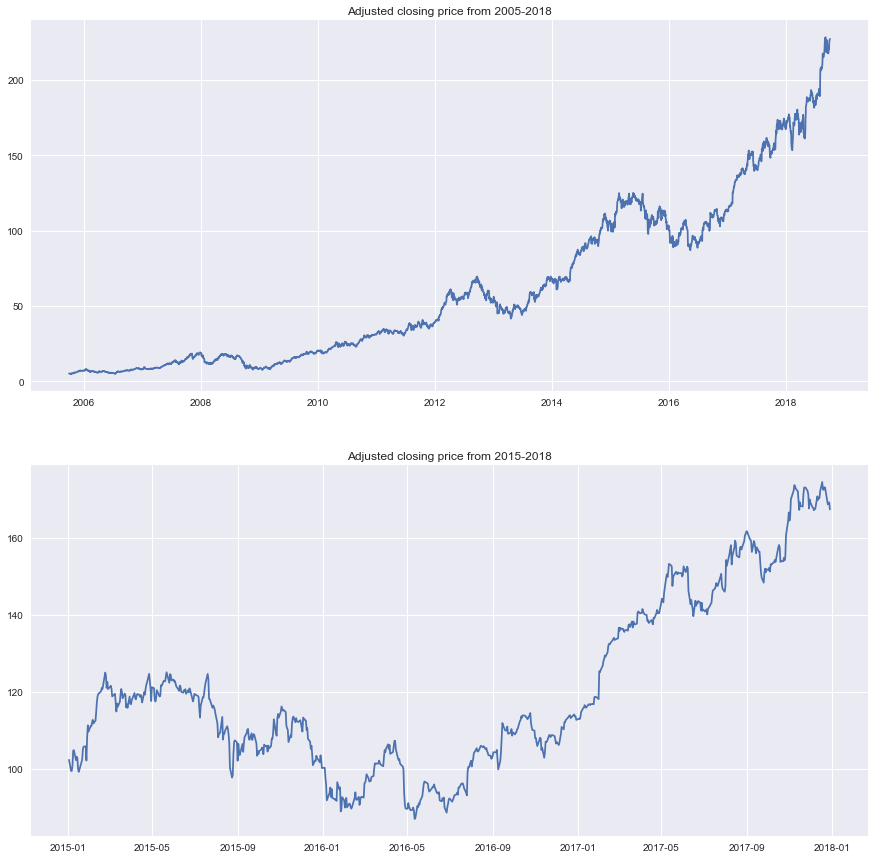

In [21]:
fig, ax = plt.subplots(2,figsize=(15,15))
# ensure that the x axis plots based on time, instead of index
# plt.plot(aapl['Date'][0:5],aapl['Adj Close'][0:5],'-ro')
ax[0].plot(aapl['Date'],aapl['Adj Close'])
ax[0].set_title('Adjusted closing price from 2005-2018')
aapl_1518 = aapl[(aapl['Date']>=pd.to_datetime('2015')) & (aapl['Date']<=pd.to_datetime('2018'))]
ax[1].plot(aapl_1518['Date'], aapl_1518['Adj Close'])
ax[1].set_title('Adjusted closing price from 2015-2018')
fig.savefig('adj close')

**Characteristics of dataset**

On visual inspection, we can identify the following characteristics in the time-series dataset

1. **Trend:** The dataset shows an increasing trend through the years
2. **Seasonality:** The dataset appears to show a weak degree of seasonality with the stock price rising during the first half of the year and falling during the second half of the year
3. **Stationarity:** The dataset is non-stationary. It does not have a constant mean over time and variance appears to be increasing. 
4. **Noise:** While there are occasional instances of volatility, as observed by the dense fluctuations at the end of 2017, the dataset shows a stable increasing trend with limited noise. 
5. **Outlier:** There are occassional outliers as seen in the period between Jul-Sep 2015, where there is a sharp rise in stock prices in the general downward trend

### Data extraction and plotting of fundementals

In [51]:
main = pd.read_csv("AAPL - main.csv", parse_dates=[0], index_col=0)
main.head()

,Cash Ratio,Gross Margin,Revenue,Inventory to Cash Days,Basic EPS,Adj Close,Stochastic Oscillator,Relative Strength Index 14,Sma 12,Sma 26,Cci 30
Date,,,,,,,,,,,
2008-09-26,0.954364,0.81411,0.776060,0.716358,0.173406,0.152270,0.192464,0.157604,0.026101,0.034503,0.281960
2008-09-29,0.000000,0.00000,0.302049,0.000000,0.000000,0.091480,0.085846,0.019386,0.024023,0.033090,0.206647
2008-09-30,0.000000,0.00000,0.302049,0.000000,0.000000,0.115116,0.249427,0.137354,0.022476,0.031797,0.239825
2008-10-01,0.000000,0.00000,0.302049,0.000000,0.000000,0.102567,0.169515,0.111857,0.021107,0.030499,0.249735
2008-10-02,0.000000,0.00000,0.302049,0.000000,0.000000,0.076007,0.002097,0.066148,0.019363,0.028993,0.238926


In [12]:
incomestmt = pd.read_excel("AAPL/AAPL - Income Statement.xlsx",index_col=0, header=3)
incomestmt = incomestmt.iloc[:,1:] # remove hidden column
incomestmt.head()

,Q4 2008,Q1 2009,Q2 2009,Q3 2009,Q4 2009,Q1 2010,Q2 2010,Q3 2010,Q4 2010,Q1 2011,...,Q2 2016,Q3 2016,Q4 2016,Q1 2017,Q2 2017,Q3 2017,Q4 2017,Q1 2018,Q2 2018,Q3 2018
In Thousands of USD except Per Share,,,,,,,,,,,,,,,,,,,,,
3 Months Ending,09/27/2008,12/27/2008,03/28/2009,06/27/2009,09/26/2009,12/26/2009,03/27/2010,06/26/2010,09/25/2010,12/25/2010,...,03/26/2016,06/25/2016,09/24/2016,12/31/2016,04/01/2017,07/01/2017,09/30/2017,12/30/2017,03/31/2018,06/30/2018
Income Statement,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Revenues,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Revenues,11520000,11880000,9084000,9734000,12207000,15683000,13499000,15700000,20343000,26741000,...,50557000,42358000,46852000,78351000,52896000,45408000,52579000,88293000,61137000,53265000
Total Revenue,—,—,—,—,—,—,—,—,—,—,...,—,—,—,—,—,—,—,—,61137000,—


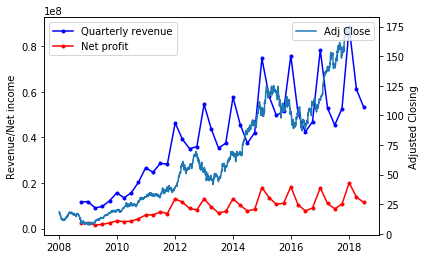

In [15]:
#plt.plot(incomestmt.loc['Revenues',:],'-b.',label='Quarterly revenue')
fig, ax1 = plt.subplots()
ax1.set_ylabel('Revenue/Net income')
ax1.plot(pd.to_datetime(incomestmt.loc['3 Months Ending',:]),incomestmt.loc['Revenues',:],'-b.',label='Quarterly revenue')
ax1.plot(pd.to_datetime(incomestmt.loc['3 Months Ending',:]),incomestmt.loc['Net Income',:],'-r.',label='Net profit')
ax1.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Adjusted Closing')
aapl_0818 = aapl[(aapl['Date']>=pd.to_datetime('2008')) & (aapl['Date']<=pd.to_datetime('2018'))]
ax2.plot(aapl_0818['Date'],aapl_0818['Adj Close'])# superimpose stock price to see if there is any correlation
ax2.legend(loc=1)

plt.xticks(rotation='vertical')
ax = plt.gca()
ax.xaxis.grid(True,linestyle='--')
plt.show()

We observe a seasonal pattern in quarterly revenue, where the revenue generated for Q1 is always higher than the rest of the quarters. Revenue and profit reporting might have certain correlation.

### Applying moving average to smooth the dataset

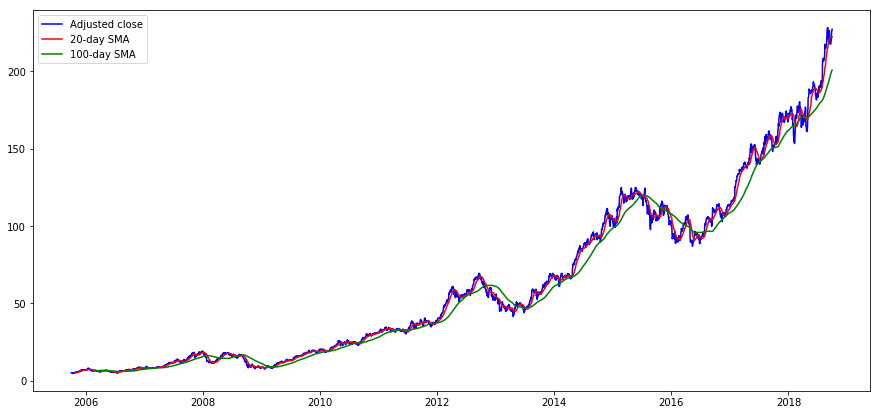

In [14]:
plt.figure(figsize=(15,7))
plt.plot(aapl['Date'],aapl['Adj Close'],'-b',label='Adjusted close')
plt.plot(aapl['Date'],aapl['Adj Close'].rolling(window=20).mean(),'-r',label='20-day SMA')
plt.plot(aapl['Date'],aapl['Adj Close'].rolling(window=100).mean(),'-g',label='100-day SMA')
plt.legend()

Applying a 20-day and 100-day moving average reduces the daily price noise by 'averaging-out' and smoothen the dataset significantly, thus providing a more long term view of the price trend. 

### Time series decomposition

We can decompose the time series data into 3 components: _seasonal_, _trend_ and _residual_ in order to capture the historical patterns in the series for building a better forecasting model. We would applying the decomposition on the 20-day moving average, since it provides a good balance between excessive noise and information loss 

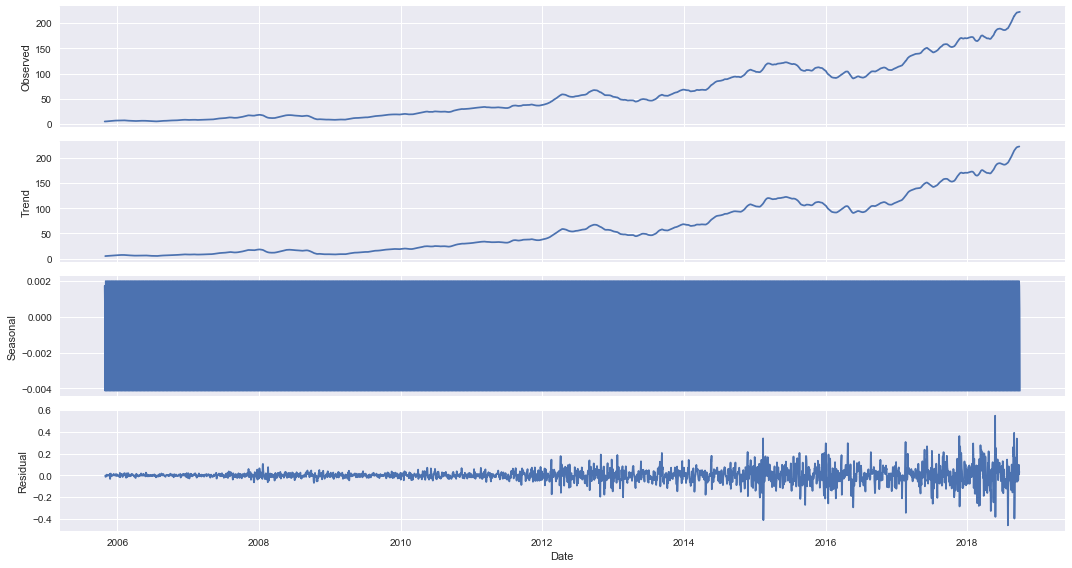

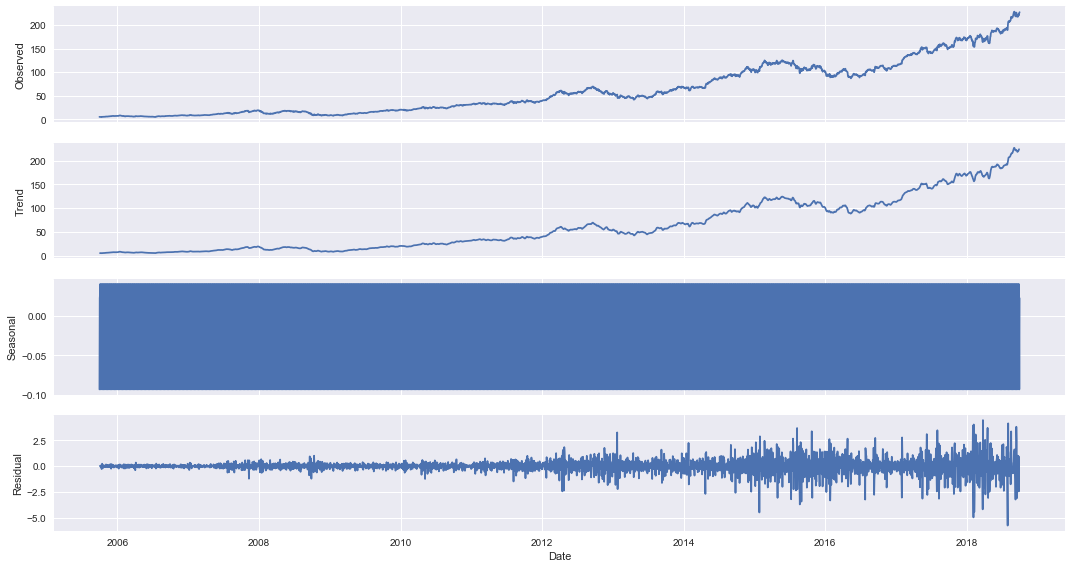

In [22]:
from pylab import rcParams
rcParams['figure.figsize'] = (15,8)

# time series decomposition for 20-day MA

new_aapl = aapl[['Date', 'Adj Close']]
new_aapl = new_aapl.set_index('Date')
new_aapl['20-MA'] = new_aapl['Adj Close'].rolling(window=20).mean()
new_aapl = new_aapl[pd.notnull(new_aapl['20-MA'])] # remove NA values due to MA
new_aapl = new_aapl.drop('Adj Close',axis=1)  # drop the Adj Close column
# print(pd.infer_freq(new_aapl.index)) # unable to infer due to erratic days. we assume business daily instead
new_aapl = new_aapl.asfreq('B', method='ffill') # forward fill holes in reindexed due to holidays i think
decomposition = sm.tsa.seasonal_decompose(new_aapl, model='additive')
fig = decomposition.plot()
fig.savefig('time decomp')

# time series decomposition for adj close

new2_aapl = aapl[['Date', 'Adj Close']]
new2_aapl = new2_aapl.set_index('Date')
new2_aapl = new2_aapl.asfreq('B', method='ffill')
decomposition2 = sm.tsa.seasonal_decompose(new2_aapl, model='additive')
fig2 = decomposition2.plot()

plt.show()

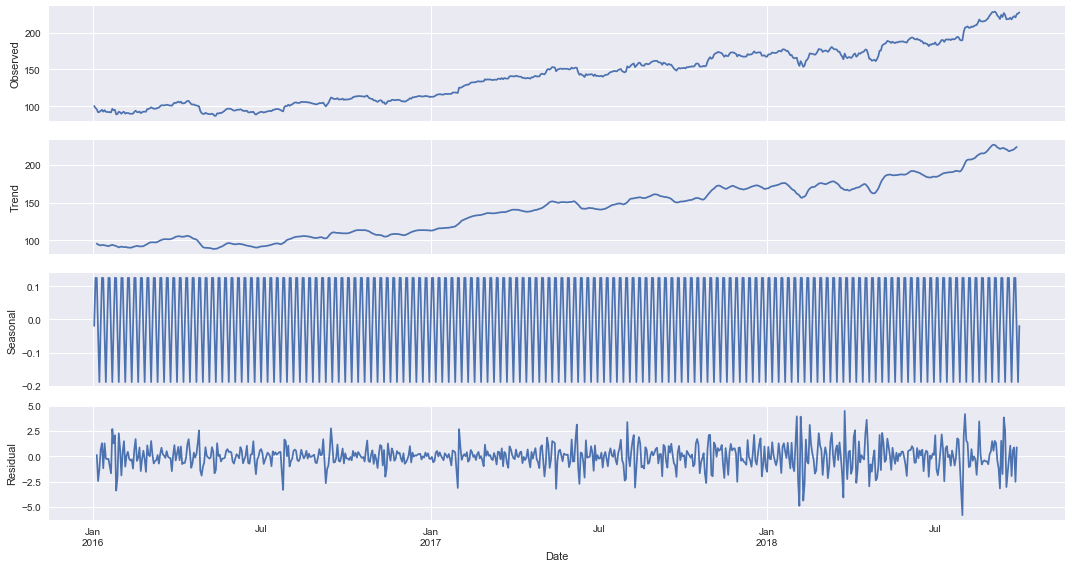

In [23]:
# time series decomposition for adj close from 2016

new3_aapl = aapl[['Date', 'Adj Close']]
new3_aapl = new3_aapl[new3_aapl['Date']>=pd.to_datetime('2016')]
new3_aapl = new3_aapl.set_index('Date')
new3_aapl = new3_aapl.asfreq('B', method='ffill')
decomposition3 = sm.tsa.seasonal_decompose(new3_aapl, model='additive')
fig3 = decomposition3.plot()
fig3.savefig('time decomp 2')
plt.show()

Using time series decomposition, it appears that there is an upward moving trend for AAPL stock prices but no discernible seasonal pattern. This is rather interesting, given that one would think that AAPL would have a seasonal pattern since Apple has been renowned for organising large-scale events, such as Apple Worldwide Developers Conference (WWDC) and Apple Special Events in specific periods, which would push up their stock prices. For instance, the WWDC has largely been organised in the month of June. The lack of a seasonal pattern could be due to the long time scale that we are looking at (i.e. from 2005 to 2018) or the noise that the stock prices are subjected to.

### Applying logarithm and square-root to reduce the variance of the dataset

Because variance seems to be increasing slightly with time, where stock price tends to be more volatile at the end, we can apply a log or square-root transformation to stablize the variance. As stated in the [link](https://stats.stackexchange.com/questions/18844/when-and-why-should-you-take-the-log-of-a-distribution-of-numbers) on StackOverFlow, applying a logarithm transformation provides information on relative change, which is what we are concerned about since we are interested in the percentage changes in daily price, rather than the absolute change.

Text(0.5, 1.0, 'Square root transformation')

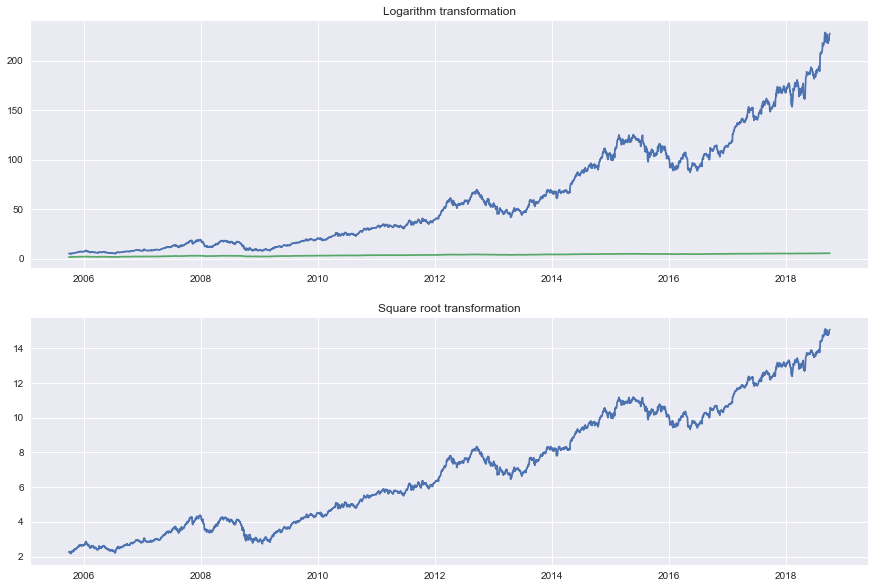

In [52]:
# logarithm transformation
fig,ax = plt.subplots(2, figsize=(15,10))
ax[0].plot(aapl['Date'],aapl['Adj Close'])
ax[0].plot(aapl['Date'],np.log(aapl['Adj Close']))
ax[0].set_title('Logarithm transformation')
ax[1].plot(aapl['Date'],np.sqrt(aapl['Adj Close']))
ax[1].set_title('Square root transformation')

### Testing for stationarity using the Dicky-Fuller test

To test for stationarity, we can apply the Dicky-Fuller test on the original stock prices of AAPL, which assumes a null hypothesis that the time series is non-stationary and we attempt to find significant evidence to reject the null hypothesis.

In [57]:
# we write a neat function to conduct the Dicky-Fuller Test
def test_stationarity(dataset):
    # Determing rolling statistics
    rolmean = dataset.rolling(window=365).mean() # MA of 1 year
    rolstd = dataset.rolling(window=365).std() # MA of 1 year
    # Plot rolling statistics
    plt.plot(dataset,label='Original')
    plt.plot(rolmean, label='Rolling Mean')
    plt.plot(rolstd, label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    fig=plt.gcf()
    plt.show()
    plt.draw()
    #fig.savefig('after differencing')
    #plt.savefig('after differencing')
    # Dicky-Fuller test
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(dataset, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

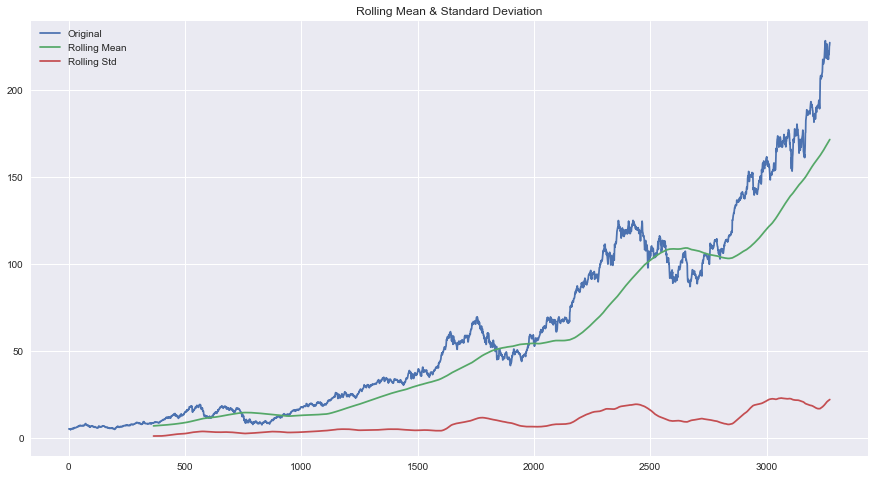

Results of Dickey-Fuller Test:
Test Statistic                    2.580586
p-value                           0.999071
#Lags Used                       19.000000
Number of Observations Used    3253.000000
Critical Value (1%)              -3.432362
Critical Value (5%)              -2.862429
Critical Value (10%)             -2.567243
dtype: float64


<Figure size 1080x576 with 0 Axes>

In [56]:
test_stationarity(aapl['Adj Close'])

A large p-value of 0.999 suggests that there is insufficient evidence to reject the null hypothesis, hence the time series is non-stationary. We also observe that the mean and S.D. are not constant over time. 

### Obtaining stationarity from a non-stationary time series

__Method 1: taking differencing using time lag__

Because the time series does not exhibit a constant mean and variance over time, this is a non-stationary time series. However, changes in stock prices are usually mean-reverting, where the change tends to remain near or return back to mean value, since stock prices would naturally go up and down over time in a consistent manner. Therefore, we can obtain a stationary time series by taking the first-order differencing.   

Text(0.5, 1.0, 'First degree differencing on sqrt data')

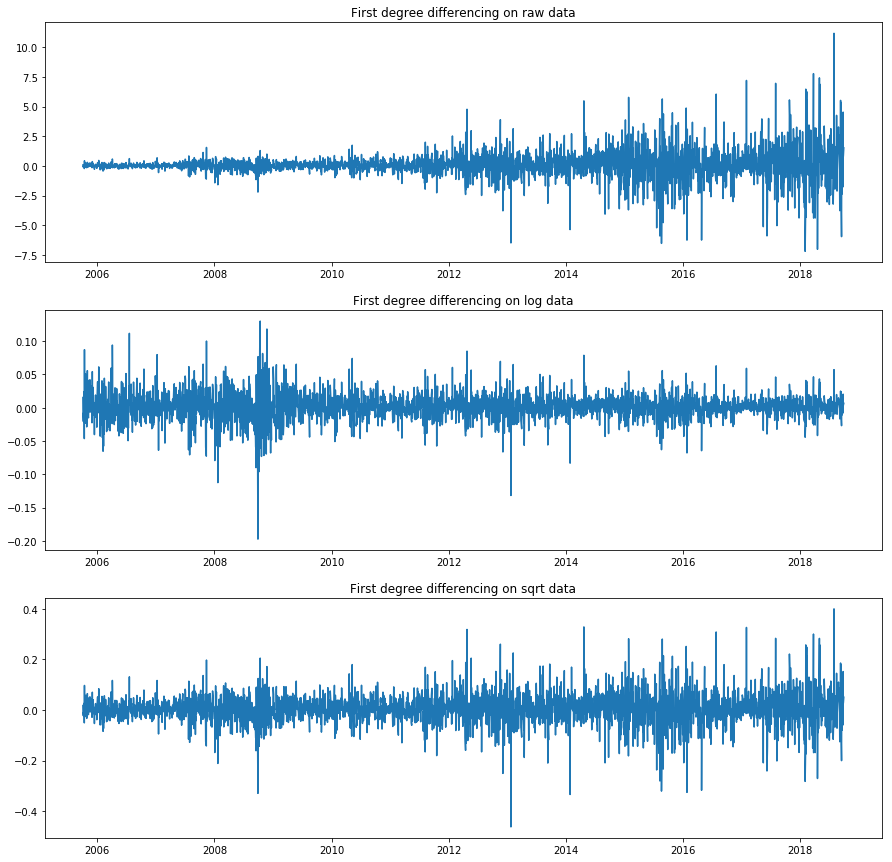

In [98]:
fig, ax = plt.subplots(3,figsize=(15,15))
ax[0].plot(aapl['Date'],aapl['Adj Close'].diff())
ax[0].set_title('First degree differencing on raw data')
ax[1].plot(aapl['Date'],np.log(aapl['Adj Close']).diff())
ax[1].set_title('First degree differencing on log data')
ax[2].plot(aapl['Date'],np.sqrt(aapl['Adj Close']).diff())
ax[2].set_title('First degree differencing on sqrt data')

We then test for stationarity test on the differences in log price

<class 'pandas.core.series.Series'>


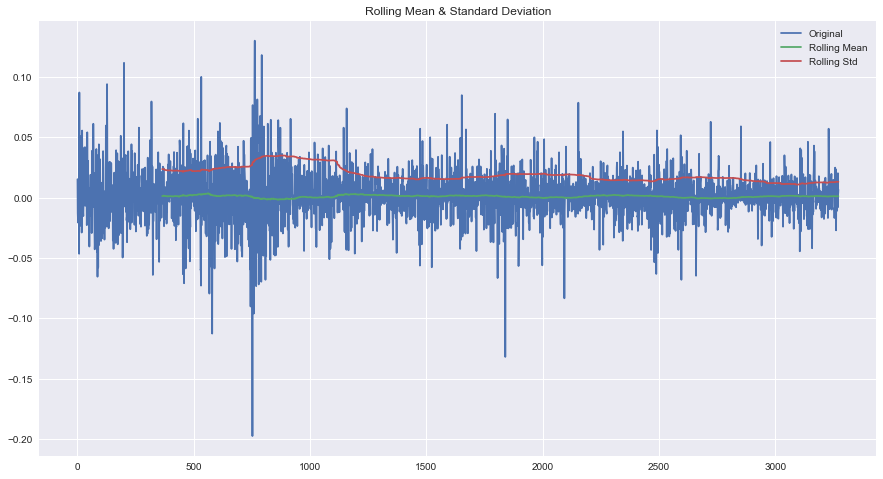

Results of Dickey-Fuller Test:
Test Statistic                  -23.365179
p-value                           0.000000
#Lags Used                        5.000000
Number of Observations Used    3266.000000
Critical Value (1%)              -3.432354
Critical Value (5%)              -2.862425
Critical Value (10%)             -2.567241
dtype: float64


<Figure size 1080x576 with 0 Axes>

In [58]:
aapl_log = np.log(aapl['Adj Close'])
aapl_log_diff = aapl_log.diff()
aapl_log_diff.dropna(inplace=True)
print(type(aapl_log_diff))
test_stationarity(aapl_log_diff)

Applying a log transformation and taking the differences, we obtain a stationary time series with mean close to 0 and a S.D. of approximately 0.02. The Dicky-Fuller test also confirms the stationarity property with an extremely small p-value that is close to 0. 

__Method 2: removing trend and seasonality effects through decomposition__

From the time series decomposition, we remove the trend and seasonality effects from the time series and determine whether the residual values are stationary in the time series

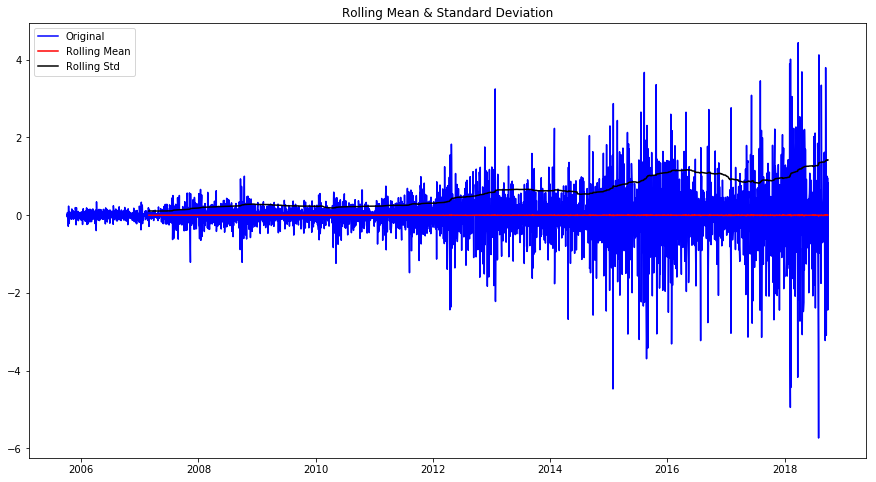

Results of Dickey-Fuller Test:
Test Statistic                -1.697009e+01
p-value                        9.172516e-30
#Lags Used                     2.800000e+01
Number of Observations Used    3.359000e+03
Critical Value (1%)           -3.432298e+00
Critical Value (5%)           -2.862401e+00
Critical Value (10%)          -2.567228e+00
dtype: float64


In [171]:
decomp_resid = decomposition2.resid.iloc[:,0]
decomp_resid.dropna(inplace=True)
test_stationarity(decomp_resid)

The residuals follow roughly a stationary time series with a small value of p. However, because the residuals are not transformed with log, there is a high degree of variation in the later years, resulting in an increase in S.D.

## 3. Proposed Algorithm
---

### Model 1: Vanilla AR model

An Auto-Regression model has been widely used as a tool in _pair-trading_ strategy under technical analysis. Because a pair of closely related stock is likely to be strongly correlated, the differences in price between the two stock is likely to be small and mean-reverting, hence it can be modelled using an auto-regressive model. Using the same idea, we can apply it to the differences in AAPL, which would be mean-reverting as well since increases and decreases in stock prices are likely to occur at similar rates.

To determine the number of AR terms to use, we can plot the Autocorrelation Function (ACF) and the Partial Autocorrelation Function (PACF), which measure the strength of a relationship between observations in a time series with observations at prior time steps.

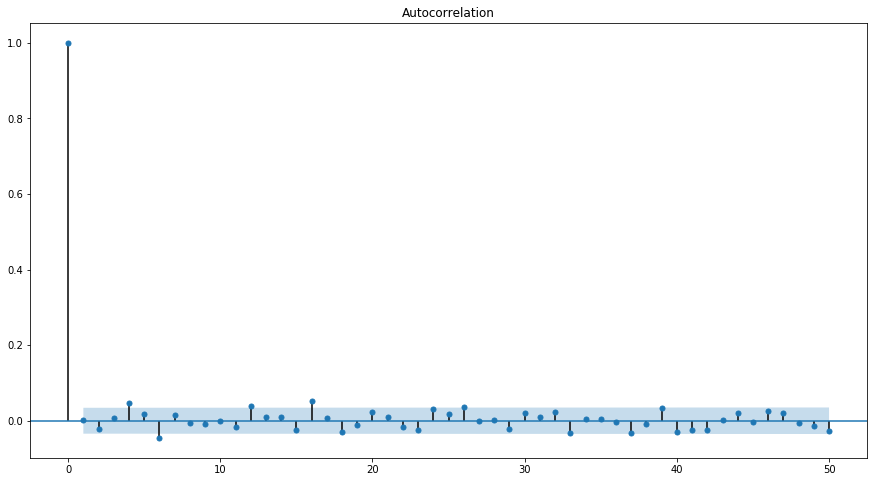

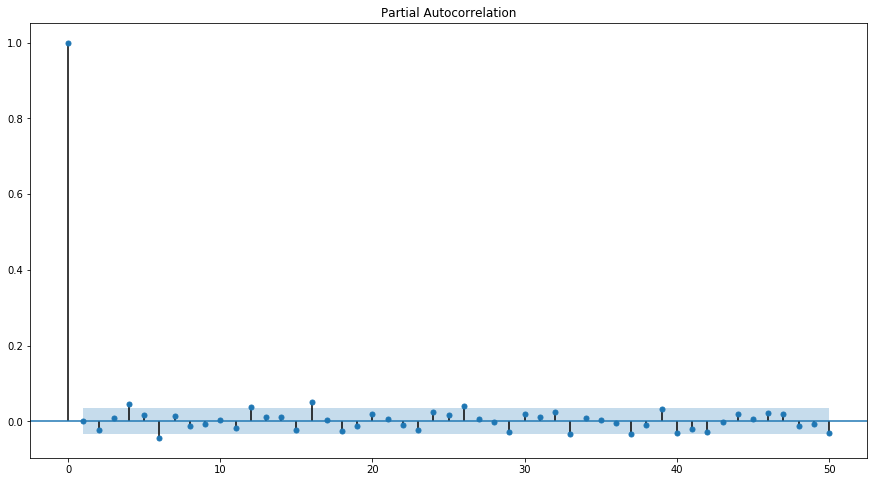

In [179]:
plot_acf(aapl_log_diff, lags=50)
plot_pacf(aapl_log_diff, lags=50)
plt.show()

The term of lag 4 shows a strong correlation in both the ACF and PACF plot, hence we can use 4 AR terms for our AR model. 

/usr/local/lib/python3.6/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/usr/local/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/usr/local/lib/python3.6/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `ar

Text(0.5, 1.0, 'RSS: 1.3423')

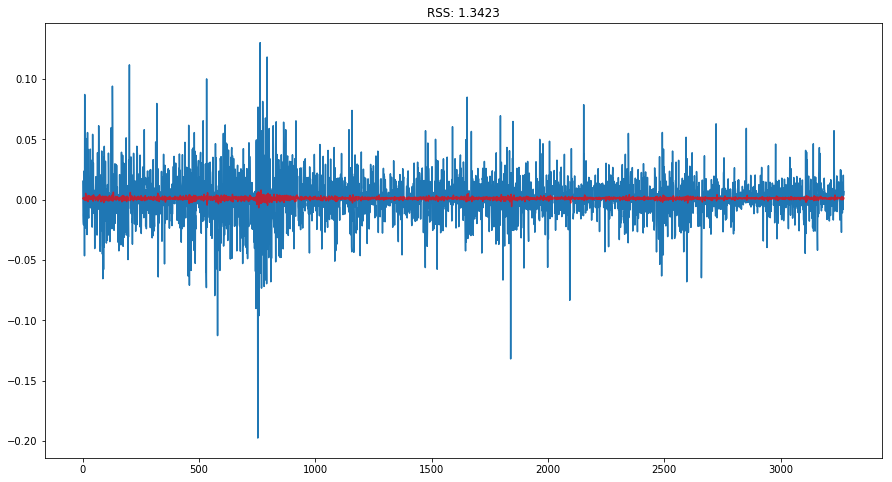

In [241]:
# new2_aapl is recalibrated dataset from time series decomposition to include frequency
# new2_aapl_log = np.log(new2_aapl['Adj Close'])
# new2_aapl_log_diff = new2_aapl_log.diff()
# new2_aapl_log_diff.dropna(inplace=True)
# ar_model = ARIMA(new2_aapl_log,order=(4,1,0))
# results_ar = ar_model.fit()
# plt.plot(new2_aapl_log_diff)
# plt.plot(results_ar.fittedvalues,color='red', alpha=0.7)
# plt.title('RSS: {:.4f}'.format(sum((results_ar.fittedvalues-new2_aapl_log_diff)**2)))

ar_model = ARIMA(aapl_log,order=(4,1,0))
results_ar = ar_model.fit()
plt.plot(aapl_log_diff)
plt.plot(results_ar.fittedvalues,color='red', alpha=0.7)
plt.title('RSS: {:.4f}'.format(sum((results_ar.fittedvalues-aapl_log_diff)**2)))

# not sure why unable to plot ARIMA model..need to figure out why